In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string

In [2]:
def readdata(filename,Labels,Data_points):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    data = np.zeros ([Data_points, len(Labels)])

    for line in src:
        #print line
        # Here we initialize the ngspice data array
        '''
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        '''
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len (temp_list)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if line[0].isdigit():
            temp_data = [float(x) for x in line.split()]

            for c in range(n_columns):
                r = fill[c]
                #print(r, index [c])

                data [r][index[c]] = temp_data [c]

                fill [c] = fill [c] + 1
                if fill [c] == Data_points:
                    fill [c] = 0
    return data

In [21]:
# Fitting model including resistance 
def model_func(I,Rt,Ic,n):
    V0 = 100E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

# CORC model for 4 layers of 1 tape each

<img src="CORC-4layer.png">
<img src="4layer-helix.png">

### Assupmtions 
- We assumed the winding of all tapes starts from the same node. 
- All the tapes are joined at the terminals.
- We consider only one pitch length in cm.
- To simplify the model we consider only 4 divisions of each tape.

In [14]:
def generatingnetlist(filename,ns,ntapes,Ic,n,rc1,rc2,Imax,L):
    
    nodes = ((ns+1)*ntapes)+1 # Number of nodes
    num_rc1 = (ns-1)*(ntapes-1) # Total Number of contact resistances 1
    num_rc2 = (ns-2)*(ntapes-2) # Total Number of contact resistances 2
    num_rc = num_rc1 + num_rc2
    
    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']
    
    # Voltage in nodes
    for i in range(nodes):
        Labels.append(f'v({i+1})')
    # Contact resistances
    for i in range(num_rc):
        Labels.append(f'@r{i+1}[i]')
    # Voltage sources
    for i in range(ntapes):
        for j in range(ns):
            Labels.append(f'@b_{i+1}_{j+1}[i]')

    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    #print(probe)
    
    # Patameters for the model
    Rt = 5E-7 # Terminal resistance
    #n = 30 # n-value
    Ec = 1E-6 # microV/cm Electric field criterion
    #L = 0.1 # [cm] length of tape
    Vc = Ec*L
    #Imax = 250 # Maximum current
    step = 1 # Step current
    Data_points = int(Imax/step + 1)

    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n')
        output.write('I1 0 1 100\n') # Current source

        # Terminal resistances
        for i in range(ntapes):
            output.write(f'rt_i_{i+1} 1 {2+(ns+1)*i} {Rt/2}\n')
            output.write(f'rt_f_{i+1} {((ns+1)*(i+1))+1} 0 {Rt/2}\n')
            
        # Contact resistances
        i = 0
        j = 0
        k = 0
        while i<num_rc :
            if i<num_rc1:
                if i < 3:
                    output.write(f'r{i+1} {ns+3+k} {k+2} {rc1}\n')
                elif (i>2 and i <6):
                    output.write(f'r{i+1} {ns+2+k} {k+1} {rc1}\n')
                elif (i>5 and i <9):
                    output.write(f'r{i+1} {ns+1+k} {k} {rc1}\n')
                k += 2
                i += 1
            else:
                if (i>8 and i<11):
                    output.write(f'r{i+1} {(ns+1)*2+3+j} {j+3} {rc2}\n')
                elif (i>10 and i<13):
                    output.write(f'r{i+1} {(ns+1)*2+4+j} {j+4} {rc2}\n')
                j += 2
                i += 1
                
        # Voltage sources
        for i in range(ntapes):
            for j in range(ns):
                output.write(f'b_{i+1}_{j+1} {2+(ns+1)*i+j} {3+(ns+1)*i+j} V={Vc/ns}*pow((I(b_{i+1}_{j+1})/{Ic[i,j]}),{n[i,j]})\n')
        
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
    return Labels,Data_points
        

In [12]:
def contactresistances(rho,L,w):
    # Surface for the two types of contact resistances
    s1 = w*w
    s2 = ((w*L)-3*w*w)/2

    # Resistances
    rc1 = rho/s1
    rc2 = rho/s2
    return rc1,rc2

Ic
 [[100. 100. 100. 100.]
 [100.  50. 100. 100.]
 [100. 100. 100. 100.]
 [100. 100. 100. 100.]]
n
 [[30. 30. 30. 30.]
 [30. 15. 30. 30.]
 [30. 30. 30. 30.]
 [30. 30. 30. 30.]]
Imax = 500.0
Resistance for rho 1e-12 Rc1 = 6.249999999999999e-12	 Rc2 = 5.060728744939271e-14
Rho 1e-12: Rt = 1.25e-07, Ic = 363.8238, n = 26.3136, Fit-error = 9.12e-08



<IPython.core.display.Javascript object>


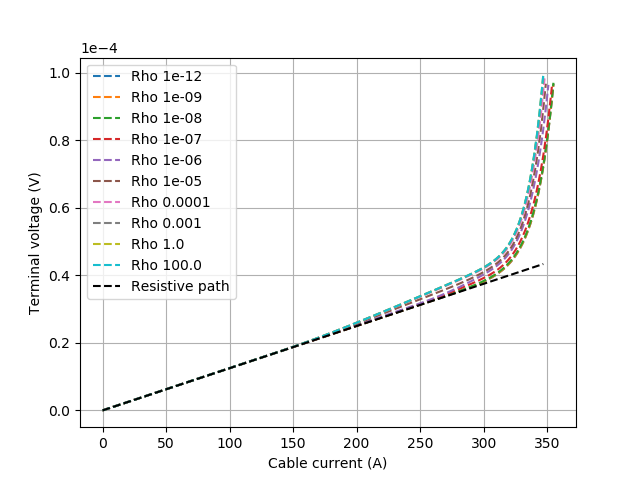

Resistance for rho 1e-09 Rc1 = 6.249999999999999e-09	 Rc2 = 5.060728744939271e-11
Rho 1e-09: Rt = 1.25e-07, Ic = 363.8452, n = 26.2798, Fit-error = 1.165e-07

Resistance for rho 1e-08 Rc1 = 6.249999999999998e-08	 Rc2 = 5.060728744939271e-10
Rho 1e-08: Rt = 1.253e-07, Ic = 364.0004, n = 25.7739, Fit-error = 8.039e-07

Resistance for rho 1e-07 Rc1 = 6.249999999999998e-07	 Rc2 = 5.06072874493927e-09
Rho 1e-07: Rt = 1.261e-07, Ic = 363.6988, n = 24.293, Fit-error = 3.4753e-06

Resistance for rho 1e-06 Rc1 = 6.249999999999999e-06	 Rc2 = 5.060728744939271e-08
Rho 1e-06: Rt = 1.272e-07, Ic = 361.0502, n = 23.6799, Fit-error = 5.7726e-06

Resistance for rho 1e-05 Rc1 = 6.249999999999999e-05	 Rc2 = 5.060728744939271e-07
Rho 1e-05: Rt = 1.302e-07, Ic = 358.4906, n = 25.3086, Fit-error = 9.1221e-06

Resistance for rho 0.0001 Rc1 = 0.0006249999999999999	 Rc2 = 5.060728744939271e-06
Rho 0.0001: Rt = 1.324e-07, Ic = 357.4575, n = 24.8929, Fit-error = 1.32166e-05

Resistance for rho 0.001 Rc1 = 0.006

In [51]:
%matplotlib notebook

# Parameters of the tape
L = 100 # cm Length of the tape for 1 pitch length
w = 0.4 # cm Width of the tape

# Parameters for the netlist
ntapes = 4
ns = 4

Ic_mean = 100 # [A]
Ic_defect = 50 # [A]
n_mean = 30
n_defect = 15
Ic = np.zeros((ntapes,ns))+Ic_mean
Ic[1,1]= Ic_defect
n = np.zeros((ntapes,ns))+n_mean
n[1,1]= n_defect
print('Ic\n',Ic)
print('n\n',n)
Imax = ntapes*Ic_mean*1.25
print(f'Imax = {Imax}')


# Testing different contact resistivities
rhos = np.array([1E-8,1E-6])
rhos = np.array([1E-12,1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1,100])
for i in range(len(rhos)):
    
    filename = f'CORC 4 layers-1 tape rho {rhos[i]}.cir'
    
    # Calculating resistances 
    rc1,rc2 = contactresistances(rhos[i],L,w)
    print(f'Resistance for rho {rhos[i]} Rc1 = {rc1}\t Rc2 = {rc2}')
    
    Labels, Data_points = generatingnetlist(filename,ns,ntapes,Ic,n,rc1,rc2,Imax,L)


    data = readdata(filename,Labels,Data_points)

    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rho {rhos[i]}')
    
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
       
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rho {rhos[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,'--',label = f'Rho {rhos[i]}')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rho {rhos[i]}')

plt.plot(Icable_lim,1.25E-7*Icable_lim,'--k',label='Resistive path')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Cable current (A)')
plt.ylabel('Terminal voltage (V)')
#plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()

plt.show()
#plt.savefig(f'Plots/Terminal voltage.png')



#### First conclusions:

- If Ic and n is uniform in all tapes, the resulting terminal voltage is the same for all values of contact resistivity rho. Since in this case current is distributed evenly in all tapes. 
- If we introduce a defect in one of the sections of the cable (in this case tape 3 section 2) then we observed that lower terminal voltage is obtained for lower contact resistance. 
- In this case we can identified that rho>1E-4 (contact resistivity reported in papers) the behavior is similar (insulation).
- On the other hand rho<1E-8 the behavior corresponds to non-insulation.

### Here I reduced the number of tapes to 2 to see if we were able to obtain the results from previous cases


<img src="2layers-1tape.png">

Ic
 [[100. 100. 100. 100.]
 [100.  50. 100. 100.]]
n
 [[30. 30. 30. 30.]
 [30. 15. 30. 30.]]
Imax = 250.0
Resistance for rho 1e-12 Rc1 = 6.249999999999999e-12	 Rc2 = 5.060728744939271e-14
Rho 1e-12: Rt = 2.499e-07, Ic = 157.2041, n = 22.4365, Fit-error = 1.253e-07



<IPython.core.display.Javascript object>


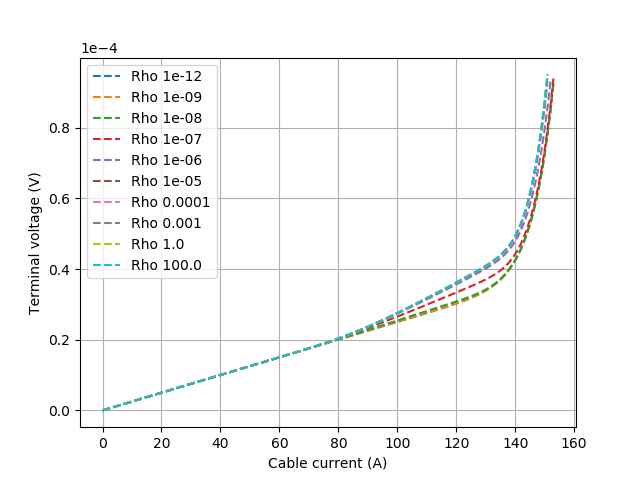

Resistance for rho 1e-09 Rc1 = 6.249999999999999e-09	 Rc2 = 5.060728744939271e-11
Rho 1e-09: Rt = 2.503e-07, Ic = 157.1971, n = 22.4769, Fit-error = 2.705e-07

Resistance for rho 1e-08 Rc1 = 6.249999999999998e-08	 Rc2 = 5.060728744939271e-10
Rho 1e-08: Rt = 2.531e-07, Ic = 157.1669, n = 22.7834, Fit-error = 1.6251e-06

Resistance for rho 1e-07 Rc1 = 6.249999999999998e-07	 Rc2 = 5.06072874493927e-09
Rho 1e-07: Rt = 2.651e-07, Ic = 157.4808, n = 22.1915, Fit-error = 8.9293e-06

Resistance for rho 1e-06 Rc1 = 6.249999999999999e-06	 Rc2 = 5.060728744939271e-08
Rho 1e-06: Rt = 2.732e-07, Ic = 157.8863, n = 18.7565, Fit-error = 1.53828e-05

Resistance for rho 1e-05 Rc1 = 6.249999999999999e-05	 Rc2 = 5.060728744939271e-07
Rho 1e-05: Rt = 2.745e-07, Ic = 156.9474, n = 18.6198, Fit-error = 1.66562e-05

Resistance for rho 0.0001 Rc1 = 0.0006249999999999999	 Rc2 = 5.060728744939271e-06
Rho 0.0001: Rt = 2.75e-07, Ic = 156.5556, n = 19.0125, Fit-error = 1.69677e-05

Resistance for rho 0.001 Rc1 = 0

In [52]:
%matplotlib notebook

# Parameters of the tape
L = 100 # cm Length of the tape for 1 pitch length
w = 0.4 # cm Width of the tape

# Parameters for the netlist
ntapes = 2
ns = 4

Ic_mean = 100 # [A]
Ic_defect = 50 # [A]
n_mean = 30
n_defect = 15
Ic = np.zeros((ntapes,ns))+Ic_mean
Ic[1,1]= Ic_defect
n = np.zeros((ntapes,ns))+n_mean
n[1,1]= n_defect
print('Ic\n',Ic)
print('n\n',n)
Imax = ntapes*Ic_mean*1.25
print(f'Imax = {Imax}')

# Testing different contact resistivities
rhos = np.array([1E-12,1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1,100])
for i in range(len(rhos)):
    
    filename = f'version1/CORC 2 layers-1 tape rho {rhos[i]}.cir'
    
    # Calculating resistances 
    rc1,rc2 = contactresistances(rhos[i],L,w)
    print(f'Resistance for rho {rhos[i]} Rc1 = {rc1}\t Rc2 = {rc2}')
    
    Labels, Data_points = generatingnetlist(filename,ns,ntapes,Ic,n,rc1,rc2,Imax,L)


    data = readdata(filename,Labels,Data_points)

    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rho {rhos[i]}')
    
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
       
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rho {rhos[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,'--',label = f'Rho {rhos[i]}')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rho {rhos[i]}')
    
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Cable current (A)')
plt.ylabel('Terminal voltage (V)')
#plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()
plt.show()
#plt.savefig(f'Plots/Terminal voltage.png')


### Observations from having two tapes using the same definition to generate the netlist
- We try different values of the contact resistivity to understand which value will work as insulation and which value will work as non-insulation. 
- We can see that rho>1E-5 serves as a insulation, terminal voltage is the same after this value.
- For rho<1E-8 the terminal voltage is observed to have the behavior of non-insulation. 